In [1]:
import copy
import json
import os
from pathlib import Path
import sys
import warnings

import torch
from anndata import AnnData
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import tqdm
import gseapy as gp

from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)

sys.path.insert(0, "../")
import scgpt as scg
from scgpt.tasks import GeneEmbedding
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.model import TransformerModel
from scgpt.preprocess import Preprocessor
from scgpt.utils import set_seed

os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'anndata'

In [9]:
set_seed(42)
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
n_hvg = 1200
n_bins = 51
mask_value = -1
pad_value = -2
n_input_bins = n_bins

In [2]:

pip install anndata



SyntaxError: invalid syntax (1427857734.py, line 1)

Step 1: Load pre-trained model and dataset

In [10]:
# Specify model path; here we load the pre-trained scGPT blood model
model_dir = Path("/N/u/xuexiao/Quartz/scripts/AItools/human")
model_config_file = model_dir / "args.json"
model_file = model_dir / "best_model.pt"
vocab_file = model_dir / "vocab.json"

vocab = GeneVocab.from_file(vocab_file)
for s in special_tokens:
    if s not in vocab:
        vocab.append_token(s)

# Retrieve model parameters from config files
with open(model_config_file, "r") as f:
    model_configs = json.load(f)
print(
    f"Resume model from {model_file}, the model args will override the "
    f"config {model_config_file}."
)
embsize = model_configs["embsize"]
nhead = model_configs["nheads"]
d_hid = model_configs["d_hid"]
nlayers = model_configs["nlayers"]
n_layers_cls = model_configs["n_layers_cls"]

gene2idx = vocab.get_stoi()

Resume model from /N/u/xuexiao/Quartz/scripts/scRNAseq/human/best_model.pt, the model args will override the config /N/u/xuexiao/Quartz/scripts/scRNAseq/human/args.json.


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ntokens = len(vocab)  # size of vocabulary
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    vocab=vocab,
    pad_value=pad_value,
    n_input_bins=n_input_bins,
)

try:
    model.load_state_dict(torch.load(model_file, map_location=torch.device('cpu')))
    print(f"Loading all model params from {model_file}")
except:
    # only load params that are in the model and match the size
    model_dict = model.state_dict()
    pretrained_dict = torch.load(model_file, map_location=torch.device('cpu'))
    pretrained_dict = {
        k: v
        for k, v in pretrained_dict.items()
        if k in model_dict and v.shape == model_dict[k].shape
    }
    for k, v in pretrained_dict.items():
        print(f"Loading params {k} with shape {v.shape}")
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)

model.to(device)

Loading params encoder.embedding.weight with shape torch.Size([60697, 512])
Loading params encoder.enc_norm.weight with shape torch.Size([512])
Loading params encoder.enc_norm.bias with shape torch.Size([512])
Loading params value_encoder.linear1.weight with shape torch.Size([512, 1])
Loading params value_encoder.linear1.bias with shape torch.Size([512])
Loading params value_encoder.linear2.weight with shape torch.Size([512, 512])
Loading params value_encoder.linear2.bias with shape torch.Size([512])
Loading params value_encoder.norm.weight with shape torch.Size([512])
Loading params value_encoder.norm.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.0.self_attn.out_proj.weight with shape torch.Size([512, 512])
Loading params transformer_encoder.layers.0.self_attn.out_proj.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.0.linear1.weight with shape torch.Size([512, 512])
Loading params transformer_encoder.layers.0.linear1.bias with 

Loading params transformer_encoder.layers.9.linear2.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.9.norm1.weight with shape torch.Size([512])
Loading params transformer_encoder.layers.9.norm1.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.9.norm2.weight with shape torch.Size([512])
Loading params transformer_encoder.layers.9.norm2.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.10.self_attn.out_proj.weight with shape torch.Size([512, 512])
Loading params transformer_encoder.layers.10.self_attn.out_proj.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.10.linear1.weight with shape torch.Size([512, 512])
Loading params transformer_encoder.layers.10.linear1.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.10.linear2.weight with shape torch.Size([512, 512])
Loading params transformer_encoder.layers.10.linear2.bias with shape torch.Size([512])
Loading p

TransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(60697, 512, padding_idx=60694)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, el

In [17]:
# Specify data path; here we load the Immune Human dataset
data_dir = Path("/N/u/xuexiao/Quartz/scripts/AItools/human")
adata = sc.read(
    str(data_dir / "Immune_ALL_human.h5ad"), cache=True
)  # 33506 × 12303
ori_batch_col = "batch"
adata.obs["celltype"] = adata.obs["final_annotation"].astype(str)
data_is_raw = False

In [18]:
# Preprocess the data following the scGPT data pre-processing pipeline
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=3,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=n_hvg,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
preprocessor(adata, batch_key="batch")


scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Subsetting highly variable genes ...
scGPT - INFO - Binning data ...


Step 2: Retrieve scGPT’s gene embeddings

In [19]:
# Retrieve the data-independent gene embeddings from scGPT
gene_ids = np.array([id for id in gene2idx.values()])
gene_embeddings = model.encoder(torch.tensor(gene_ids, dtype=torch.long).to(device))
gene_embeddings = gene_embeddings.detach().cpu().numpy()

In [20]:
# Filter on the intersection between the Immune Human HVGs found in step 1.2 and scGPT's 30+K foundation model vocab
gene_embeddings = {gene: gene_embeddings[i] for i, gene in enumerate(gene2idx.keys()) if gene in adata.var.index.tolist()}
print('Retrieved gene embeddings for {} genes.'.format(len(gene_embeddings)))

Retrieved gene embeddings for 1176 genes.


In [21]:
# Construct gene embedding network
embed = GeneEmbedding(gene_embeddings)

100%|██████████████████████████████████████████████████████████████████████████| 1176/1176 [00:00<00:00, 1617213.61it/s]


Step 3: Extract gene programs from gene embedding network

In [22]:
# Perform Louvain clustering with desired resolution; here we specify resolution=40
gdata = embed.get_adata(resolution=40)
# Retrieve the gene clusters
metagenes = embed.get_metagenes(gdata)

2024-07-11 16:20:42.705400: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /N/soft/rhel8/python/gnu/3.10.5/lib:/N/soft/rhel8/sqlite/gnu/3.35.5/lib:/N/soft/rhel8/mvapich/gnu/2.3.5/lib:/N/soft/rhel8/gcc/9.3.0/lib64:/N/soft/rhel8/gcc/9.3.0/lib
2024-07-11 16:20:42.705429: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [23]:
# Obtain the set of gene programs from clusters with #genes >= 5
mgs = dict()
for mg, genes in metagenes.items():
    if len(genes) > 4:
        mgs[mg] = genes

In [24]:
# Here are the gene programs identified
mgs

{'49': ['P2RY8', 'ITPKB', 'CDC14A', 'RBM38', 'RNF125'],
 '67': ['ZFP36', 'SOCS3', 'SLC2A3', 'KLF10', 'CDKN1A'],
 '52': ['ZEB2', 'CSGALNACT1', 'MEF2C', 'PTPRE', 'TCF4'],
 '68': ['ZCCHC7', 'SUPT3H', 'SCAPER', 'FHIT', 'TFDP2'],
 '26': ['YPEL3', 'TUBB2A', 'TUBA4A', 'BEX5', 'BEX2', 'PGRMC1'],
 '13': ['YIPF6', 'GDE1', 'DPM2', 'CCS', 'PIGC', 'ATG4A', 'FAM104A'],
 '17': ['XPO7', 'TRAK2', 'FBXO9', 'CDC27', 'NCEH1', 'OPA1', 'PPME1'],
 '28': ['XCL2', 'LAIR2', 'KLRC1', 'KIR2DL3', 'XCL1', 'CRTAM'],
 '75': ['VSIG4', 'C1QA', 'C1QC', 'C1QB', 'CD68'],
 '12': ['VPREB3', 'VPREB1', 'TCL1A', 'CD79B', 'IGLL1', 'IGLL5', 'DNTT'],
 '41': ['VNN2', 'FCGR3B', 'CMTM2', 'PPM1N', 'PROK2'],
 '46': ['UBE2O', 'PRKAR1B', 'APBA2', 'MIAT', 'RNF157'],
 '65': ['TYROBP', 'SRGN', 'FCER1G', 'CAPG', 'ALOX5AP'],
 '70': ['ZNF860', 'KCNG1', 'FAM214B', 'FBXO30', 'PLXNA3'],
 '18': ['TUBB1', 'GP9', 'TMEM40', 'ACRBP', 'RGS18', 'PPBP', 'PF4'],
 '47': ['TTN', 'TFCP2L1', 'CCDC141', 'GCNT2', 'RASGRP3'],
 '24': ['TRIM23', 'HPCAL4', 'ZSCAN1

Step 4: Visualize gene program activation on the Immune Human dataset

<Figure size 360x936 with 0 Axes>

<Figure size 432x288 with 0 Axes>

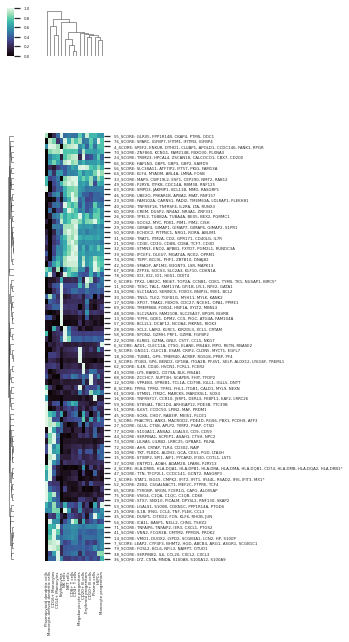

In [25]:
sns.set(font_scale=0.35)
embed.score_metagenes(adata, metagenes)
embed.plot_metagenes_scores(adata, mgs, "celltype")

Step 5: Visualize network connectivity within desired gene program

In [34]:
# Retrieve gene program 3 which contains the CD3 gene set
CD_genes = mgs['3']
print(CD_genes)
# Compute cosine similarities among genes in this gene program
df_CD = pd.DataFrame(columns=['Gene', 'Similarity', 'Gene1'])
for i in tqdm.tqdm(CD_genes):
    df = embed.compute_similarities(i, CD_genes)
    df['Gene1'] = i
    df_CD = pd.concat([df_CD, df])
df_CD_sub = df_CD[df_CD['Similarity']<0.99].sort_values(by='Gene') # Filter out edges from each gene to itself

['ITGB3', 'GP6', 'BEND2', 'GP1BA', 'ITGA2B', 'PF4V1', 'SELP', 'ALOX12', 'LY6G6F', 'TREML1']


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 428.01it/s]


In [35]:
# Creates a graph from the cosine similarity network
input_node_weights = [(row['Gene'], row['Gene1'], round(row['Similarity'], 2)) for i, row in df_CD_sub.iterrows()]
G = nx.Graph()
G.add_weighted_edges_from(input_node_weights)

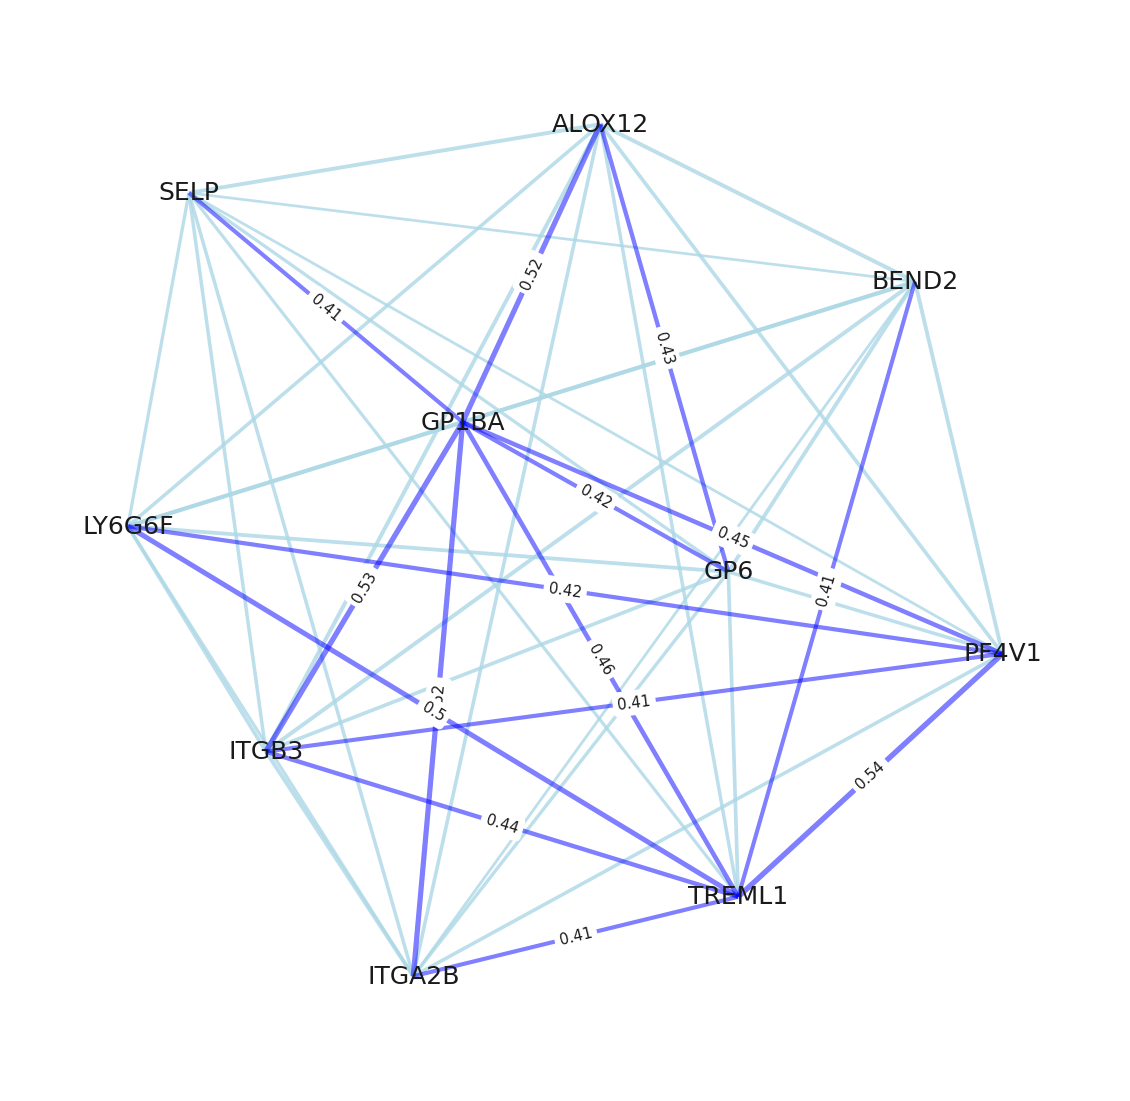

In [36]:
# Plot the cosine similarity network; strong edges (> select threshold) are highlighted
thresh = 0.4
plt.figure(figsize=(20, 20))
widths = nx.get_edge_attributes(G, 'weight')

elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > thresh]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= thresh]

pos = nx.spring_layout(G, k=0.4, iterations=15, seed=3)

width_large = {}
width_small = {}
for i, v in enumerate(list(widths.values())):
    if v > thresh:
        width_large[list(widths.keys())[i]] = v*10
    else:
        width_small[list(widths.keys())[i]] = max(v, 0)*10

nx.draw_networkx_edges(G, pos,
                       edgelist = width_small.keys(),
                       width=list(width_small.values()),
                       edge_color='lightblue',
                       alpha=0.8)
nx.draw_networkx_edges(G, pos,
                       edgelist = width_large.keys(),
                       width = list(width_large.values()),
                       alpha = 0.5,
                       edge_color = "blue",
                      )
# node labels
nx.draw_networkx_labels(G, pos, font_size=25, font_family="sans-serif")
# edge weight labels
d = nx.get_edge_attributes(G, "weight")
edge_labels = {k: d[k] for k in elarge}
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=15)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.show()

Step 6: Reactome pathway analysis

In [29]:
# Meta info about the number of terms (tests) in the databases
df_database = pd.DataFrame(
data = [['GO_Biological_Process_2021', 6036],
['GO_Molecular_Function_2021', 1274],
['Reactome_2022', 1818]],
columns = ['dataset', 'term'])

In [30]:
# Select desired database for query; here use Reactome as an example
databases = ['Reactome_2022']
m = df_database[df_database['dataset'].isin(databases)]['term'].sum()
# p-value correction for total number of tests done
p_thresh = 0.05/m

In [32]:
# Perform pathway enrichment analysis using the gseapy package in the Reactome database
df = pd.DataFrame()
enr_Reactome = gp.enrichr(gene_list=CD_genes,
                          gene_sets=databases,
                          organism='Human',
                          outdir='test/enr_Reactome',
                          cutoff=0.5)
out = enr_Reactome.results
out = out[out['P-value'] < p_thresh]
df = pd.concat([df, out], ignore_index=True)
df


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,Reactome_2022,"Platelet Activation, Signaling And Aggregation...",5/254,7.598703e-08,0.000004,0,0,79.281124,1299.631941,ITGB3;ITGA2B;GP1BA;GP6;LY6G6F
1,Reactome_2022,Hemostasis R-HSA-109582,6/576,1.058168e-07,0.000004,0,0,51.105263,820.830081,ITGB3;ITGA2B;GP1BA;GP6;LY6G6F;PF4V1
2,Reactome_2022,Platelet Aggregation (Plug Formation) R-HSA-76009,3/36,6.370875e-07,0.000014,0,0,259.181818,3697.580814,ITGB3;ITGA2B;GP1BA
3,Reactome_2022,Platelet Adhesion To Exposed Collagen R-HSA-75892,2/12,1.481031e-05,0.000252,0,0,499.500000,5554.533472,GP1BA;GP6
4,Reactome_2022,p130Cas Linkage To MAPK Signaling For Integrin...,2/15,2.354312e-05,0.000258,0,0,384.173077,4094.008378,ITGB3;ITGA2B
5,Reactome_2022,GRB2:SOS Provides Linkage To MAPK Signaling Fo...,2/15,2.354312e-05,0.000258,0,0,384.173077,4094.008378,ITGB3;ITGA2B
